In [1]:
from modules.bouncing_balls import BouncingBalls
from modules.building import build_ARTransformerNum, count_parameters
from modules.plotting import (
    show_2d_hist,
    show_emb_sim,
    show_number_line,
    show_pmfs,
    show_pos_sim,
    show_reconstruction,
    show_samples
)
from modules.resnet_ball_counter import resnet18_ball_counter
from modules.utils import BallCounter, quantize, unquantize

from training import name_experiment, transform

import os
from tqdm import tqdm

from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader

In [14]:
# dataset
DATASET_ROOT = 'datasets/uniform_dots'
BATCH_SIZE = 16

# model
SZ = 'm'
ALLW_NUMS = range(1, 9)

# ball counter
RESNET = False
RESNET_MAX_NUM = 10
RESNET_CKPT = 'resnet18'

# optimization
LR = 3e-3
EXPERIMENT_STR = 'org'
CHECKPOINT_DIR = 'checkpoints'
METADATA_DIR = 'metadata'

# generation
NUM_PCS = 2
INT_NUMS = [2, 4, 6]
ALPHAS = [0.50, 1.00, 1.50]
DATA_DIR = 'data'
OBS_NUMS = 15
STEPS = 4

In [3]:
test_set = BouncingBalls(
    DATASET_ROOT,
    split='testing',
    num=True
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE
)
test_iter = iter(test_loader)

res = test_set.res

In [15]:
model = build_ARTransformerNum(
    sz=SZ,
    num_num=max(ALLW_NUMS) + 1,
    num_positions=res**2
)
print(
    'ARTransformerNum (size \'', SZ,
    '\', ', count_parameters(model), ' parameters)',
    sep=''
)

device = torch.device('cuda:0')
_ = model.to(device)

ARTransformerNum (size 'm', 135792 parameters)


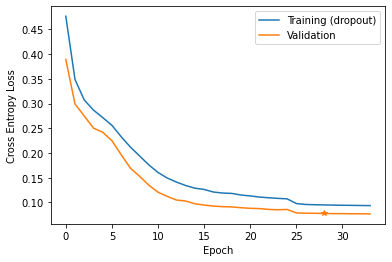

<All keys matched successfully>

In [16]:
#-----------------
# Training Summary
#-----------------

experiment_name = name_experiment(SZ, LR, EXPERIMENT_STR)

# load checkpoint and training metadata
checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, experiment_name))
metadata = torch.load(os.path.join(METADATA_DIR, experiment_name))
train_losses = metadata['train_losses']
val_losses = metadata['val_losses']

# show the summary
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( # best model
    checkpoint['epoch'] - 1,
    val_losses[checkpoint['epoch'] - 1],
    marker='*',
    c='tab:orange'
)
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training (dropout)', 'Validation'])
plt.show()

model.load_state_dict(checkpoint['model_state_dict'])

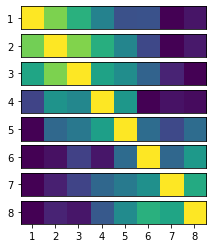

In [17]:
#----------------
# Numerosity SoSs
#----------------

soss = model.sos.weight.detach()[ALLW_NUMS]
show_emb_sim(soss, ALLW_NUMS)

['PC1: 56.59%', 'PC2: 15.99%', 'PC3: 8.97%', 'PC4: 7.82%', 'PC5: 4.78%', 'PC6: 3.80%', 'PC7: 2.05%', 'PC8: 0.00%']


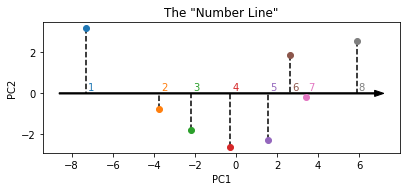

In [18]:
#------------------
# The "Number Line"
#------------------

# PCA
A = soss - torch.mean(soss, dim=0) # center data
U, S, V = torch.svd(A)
print(['PC%d: %.2f%%' % (i + 1, 100*s) for i, s in enumerate(S**2/torch.sum(S**2))])

# project onto the first 2 PCs
A_2 = torch.mm(U[:,:2], torch.diag(S[:2]))

show_number_line(A_2.cpu(), ALLW_NUMS, figsize=(6.4, 0.5*4.8))

# reproject onto the original space
soss_prj = torch.mm(A_2[:,:NUM_PCS], V[:,:NUM_PCS].T) + torch.mean(soss, dim=0)

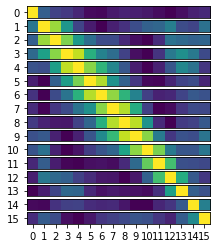

In [19]:
#-----------
# Embeddings
#-----------

show_emb_sim(model.embedding.weight.detach())

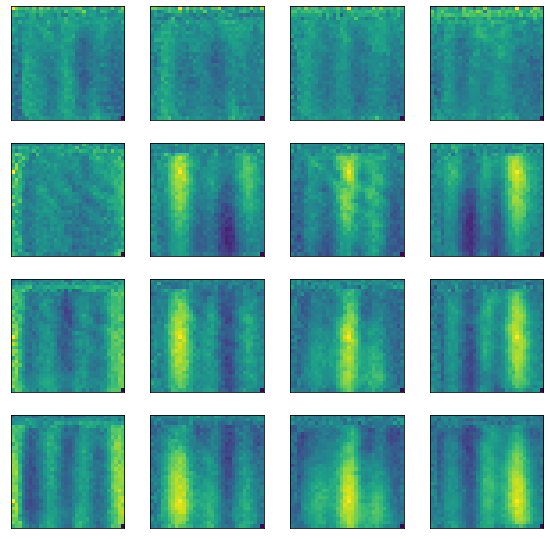

In [20]:
#---------------------
# Positional Encodings
#---------------------

show_pos_sim(model.positional_encoding.weight.detach(), figsize=(2*4.8, 2*4.8))

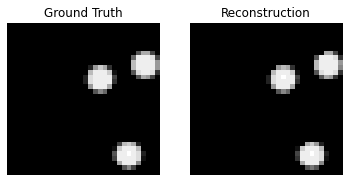

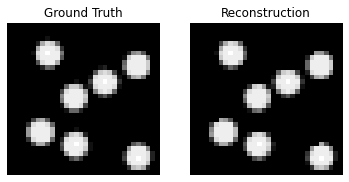

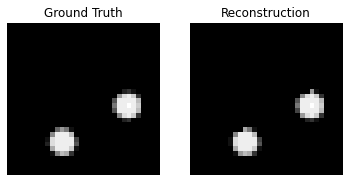

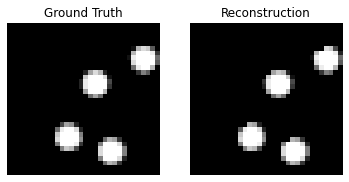

In [21]:
#-----------------------
# Conditional Generation
#-----------------------

# sample the next batch
numerosities, frames = next(test_iter)

# preprocessing
numerosities = numerosities.to(device)
frames = transform(frames).to(device)

# generate
predictions = model.predict(numerosities, frames)

# show
for i in range(4):
    gt = unquantize(frames[:,i]).view(res, res)
    prd= unquantize(predictions[:,i]).view(res, res)
    show_reconstruction(gt.cpu(), prd.cpu())

Numerosity: 1


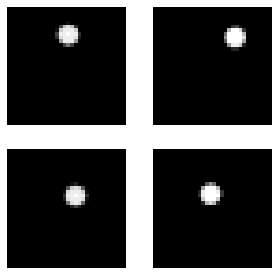

Numerosity: 2


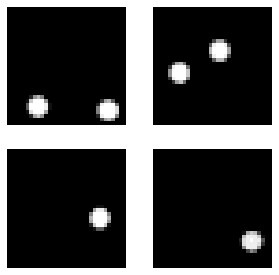

Numerosity: 3


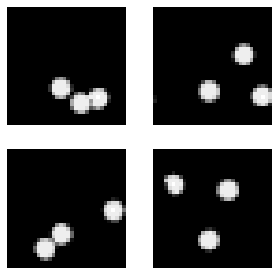

Numerosity: 4


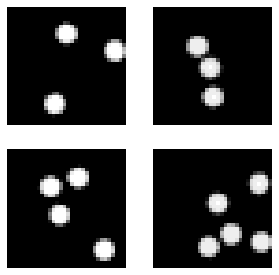

Numerosity: 5


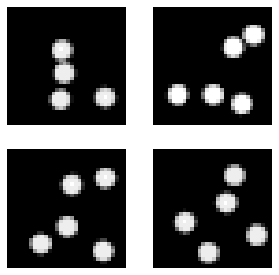

Numerosity: 6


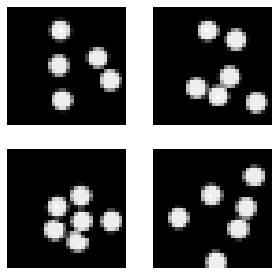

Numerosity: 7


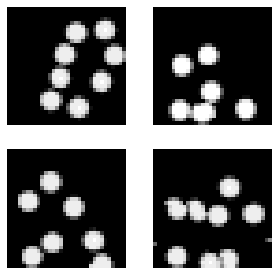

Numerosity: 8


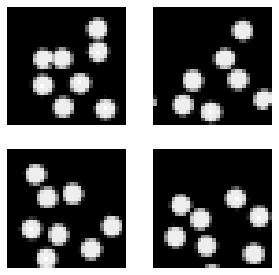

In [22]:
#------------------------------------
# Generation - Qualitative Evaluation
#------------------------------------

for n in ALLW_NUMS:
    print('Numerosity:', n)

    # initialize the batch to 0
    batch = torch.zeros(res**2, 4, dtype=torch.long, device=device)

    # generate
    batch = model.generate(
        n*torch.ones(batch.shape[1], dtype=torch.long, device=device),
        batch
    )

    # show
    show_samples(
        unquantize(batch.T.view(- 1, res, res)).cpu(),
        figsize=(4.8, 4.8)
    )

In [7]:
if not RESNET:
    counter = BallCounter(test_loader)
else:
    counter = resnet18_ball_counter(RESNET_MAX_NUM)
    counter.to(device)

    cnt_weights = torch.load(os.path.join(CHECKPOINT_DIR, RESNET_CKPT))
    counter.load_state_dict(cnt_weights['model_state_dict'])

Loading data...


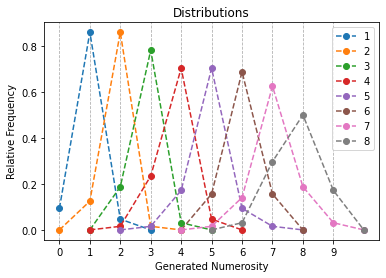

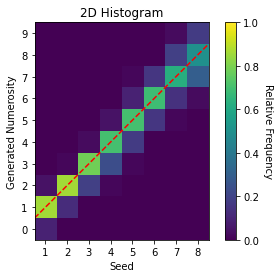

In [23]:
#--------------------------
# Generation - Learned SoSs
#--------------------------

data_name = experiment_name + '_lrn'
if os.path.isfile(os.path.join(DATA_DIR, data_name)):
    print('Loading data...')
    pmfs = torch.load(os.path.join(DATA_DIR, data_name))
else:
    frqs = torch.zeros(len(ALLW_NUMS), OBS_NUMS, dtype=torch.int, device=device)
    for i, num in enumerate(tqdm(ALLW_NUMS)):
        for step in range(STEPS):
            # initialize the batch to 0
            batch = torch.zeros(res**2, BATCH_SIZE, dtype=torch.long, device=device)

            # generate
            model.generate(
                num*torch.ones(batch.shape[1], dtype=torch.long, device=device),
                batch
            )
            
            # count
            for frame in batch.T:
                if RESNET:
                    # preprocess
                    frame = unquantize(frame)\
                        .view(1, res, res)\
                        .float()
                try:
                    frqs[i,counter.count(frame)] += 1
                except:
                    pass

    # normalize frequencies
    pmfs = frqs/torch.sum(frqs, dim=1, keepdim=True)

    torch.save(pmfs, os.path.join(DATA_DIR, data_name))

show_pmfs(pmfs.cpu(), ALLW_NUMS)
show_2d_hist(pmfs.cpu(), from_one=True)

Loading data...


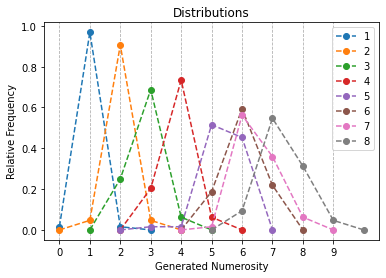

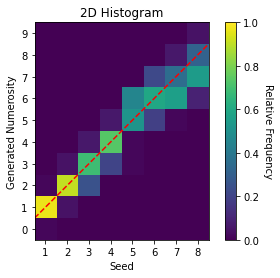

In [24]:
#------------------------------
# Generation - Reprojected SoSs
#------------------------------

data_name = experiment_name + '_pc' + str(NUM_PCS)
if os.path.isfile(os.path.join(DATA_DIR, data_name)):
    print('Loading data...')
    pmfs = torch.load(os.path.join(DATA_DIR, data_name))
else:
    frqs = torch.zeros(len(ALLW_NUMS), OBS_NUMS, dtype=torch.int, device=device)
    for i, sos in enumerate(tqdm(soss_prj)):
        for step in range(STEPS):
            # initialize the batch to 0
            batch = torch.zeros(res**2, BATCH_SIZE, dtype=torch.long, device=device)

            # generate
            model.generate(
                sos.expand(batch.shape[1], - 1),
                batch
            )
            
            # count
            for frame in batch.T:
                if RESNET:
                    # preprocess
                    frame = unquantize(frame)\
                        .view(1, res, res)\
                        .float()
                try:
                    frqs[i,counter.count(frame)] += 1
                except:
                    pass

    # normalize frequencies
    pmfs = frqs/torch.sum(frqs, dim=1, keepdim=True)

    torch.save(pmfs, os.path.join(DATA_DIR, data_name))

show_pmfs(pmfs.cpu(), ALLW_NUMS)
show_2d_hist(pmfs.cpu(), from_one=True)

Loading data...


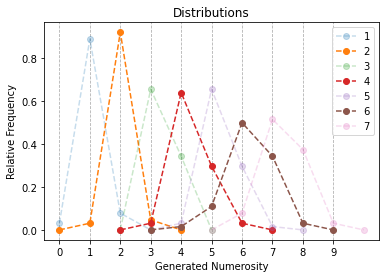

In [8]:
#-------------------------------
# Generation - Interpolated SoSs
#-------------------------------

data_name = experiment_name + '_int'
nums = range(min(ALLW_NUMS), max(ALLW_NUMS) + 1)
if os.path.isfile(os.path.join(DATA_DIR, data_name)):
    print('Loading data...')
    pmfs = torch.load(os.path.join(DATA_DIR, data_name))
else:
    frqs = torch.zeros(len(nums), OBS_NUMS, dtype=torch.int, device=device)
    for i, num in enumerate(tqdm(nums)):
        for step in range(STEPS):
            # initialize the batch to 0
            batch = torch.zeros(res**2, BATCH_SIZE, dtype=torch.long, device=device)

            if num in INT_NUMS:
                # linear interpolation
                sos = ((soss[ALLW_NUMS.index(num - 1)] + soss[ALLW_NUMS.index(num + 1)])/2)\
                    .expand(batch.shape[1], - 1)
            else:
                sos = num*torch.ones(batch.shape[1], dtype=torch.long, device=device)

            # generate
            model.generate(
                sos,
                batch
            )
            
            # count
            for frame in batch.T:
                if RESNET:
                    # preprocess
                    frame = unquantize(frame)\
                        .view(1, res, res)\
                        .float()
                try:
                    frqs[i,counter.count(frame)] += 1
                except:
                    pass

    # normalize frequencies
    pmfs = frqs/torch.sum(frqs, dim=1, keepdim=True)

    torch.save(pmfs, os.path.join(DATA_DIR, data_name))

show_pmfs(pmfs.cpu(), nums, focus=INT_NUMS, alpha=0.25)

Loading data...


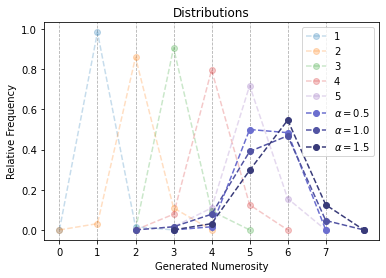

In [13]:
#-------------------------------
# Generation - Extrapolated SoSs
#-------------------------------

a = soss[-1] - soss[-2] # attribute vector
soss_xtr = [soss[-1] + alpha*a for alpha in ALPHAS] # extrapolated SoSs
soss_xtr = [sos for sos in soss] + soss_xtr

data_name = experiment_name + '_xtr'
if os.path.isfile(os.path.join(DATA_DIR, data_name)):
    print('Loading data...')
    pmfs = torch.load(os.path.join(DATA_DIR, data_name))
else:
    frqs = torch.zeros(len(soss_xtr), OBS_NUMS, dtype=torch.int, device=device)
    for i, sos in enumerate(tqdm(soss_xtr)):
        for step in range(STEPS):
            # initialize the batch to 0
            batch = torch.zeros(res**2, BATCH_SIZE, dtype=torch.long, device=device)

            # generate
            model.generate(
                sos.expand(batch.shape[1], - 1),
                batch
            )
            
            # count
            for frame in batch.T:
                if RESNET:
                    # preprocess
                    frame = unquantize(frame)\
                        .view(1, res, res)\
                        .float()
                try:
                    frqs[i,counter.count(frame)] += 1
                except:
                    pass

    # normalize frequencies
    pmfs = frqs/torch.sum(frqs, dim=1, keepdim=True)

    torch.save(pmfs, os.path.join(DATA_DIR, data_name))

labels = list(ALLW_NUMS) + ['$\\alpha = ' + str(alpha) + '$' for alpha in ALPHAS]
show_pmfs(
    pmfs.cpu(),
    labels,
    num_xtrs=len(ALPHAS),
    focus=labels[-len(ALPHAS):],
    alpha=0.25
)